# Motor position controller
In this section, the static motor controller will be created.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import time

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT, MOTOR_ERROR_SCALING, MOTOR_D_ERROR_SCALING, MOTOR_INTEGRAL_ERROR_SCALING

## Target trajectory

In [3]:
def sin_wave(amplitude: float, period: float):
    return amplitude * np.sin(np.linspace(-np.pi, np.pi, math.floor(period / DT)))

In [4]:
trajectory = np.zeros(1)
trajectory = np.concatenate((trajectory, 0. * np.ones(10)))
trajectory = np.concatenate((trajectory, 10. * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, -11. * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, 12.6 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, -13.33 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, 18.33 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, -21.3 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, 25.3 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory = np.concatenate((trajectory, -28.9 * np.ones(40)))
trajectory = np.concatenate((trajectory, 0. * np.ones(40)))

trajectory = np.concatenate((trajectory, sin_wave(25., 2.5)))
trajectory = np.concatenate((trajectory, sin_wave(20., 2.)))
trajectory = np.concatenate((trajectory, sin_wave(17., 1.5)))
trajectory = np.concatenate((trajectory, sin_wave(15., 1.2)))
trajectory = np.concatenate((trajectory, sin_wave(8., 1.1)))
trajectory = np.concatenate((trajectory, sin_wave(7., 1.)))
trajectory = np.concatenate((trajectory, sin_wave(6., 0.78)))
trajectory = np.concatenate((trajectory, sin_wave(5., 0.73)))

trajectory = np.concatenate((trajectory, 0. * np.ones(50)))

In [5]:
trajectory2 = np.cumsum(np.random.rand(len(trajectory)) - 0.5)
trajectory2 = trajectory2 / np.max(np.abs(trajectory2)) * 35

trajectory = np.concatenate((trajectory, trajectory2))

<IPython.core.display.Javascript object>


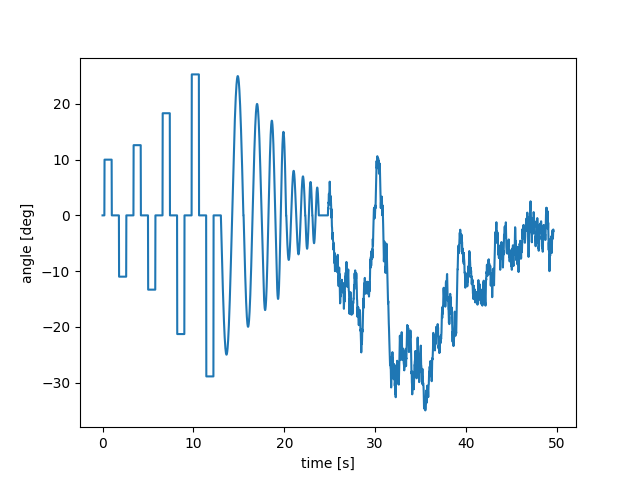

In [6]:
t = np.arange(0., len(trajectory) * DT, DT)

plt.figure()
plt.plot(t, trajectory)
plt.xlabel('time [s]')
plt.ylabel('angle [deg]')
plt.show()

<IPython.core.display.Javascript object>


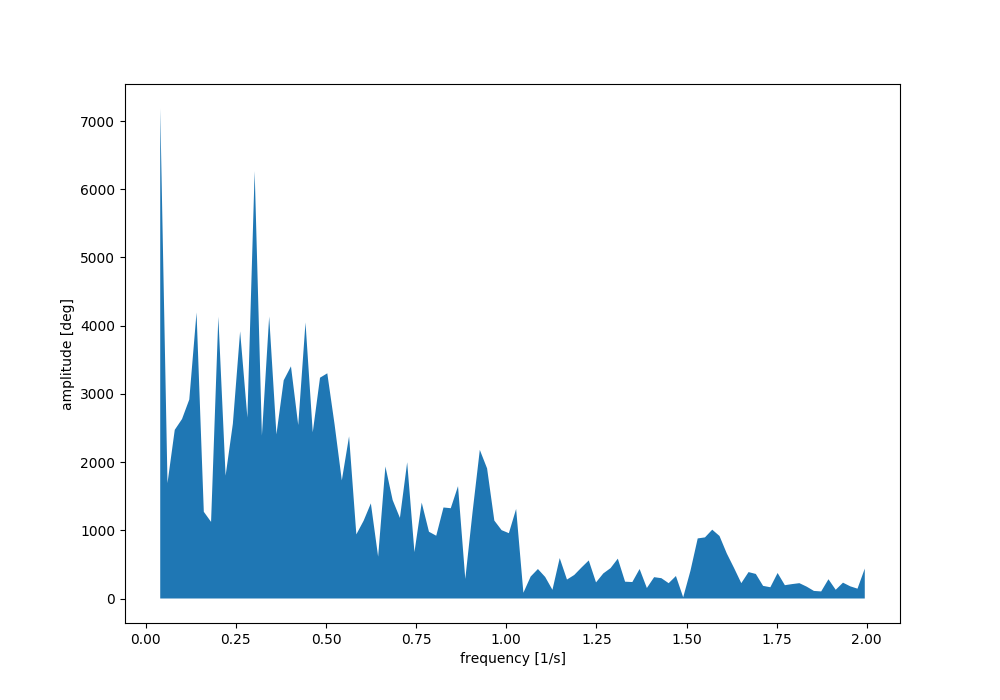

In [7]:
l = len(trajectory)
ft_t1 = np.abs(np.fft.rfft(trajectory))
#ft_t2 = np.abs(np.fft.rfft(trajectory2))
freq = np.fft.rfftfreq(l) / DT

plt.figure(figsize=(10, 7))
plt.fill_between(freq[2:100], ft_t1[2:100])
#plt.plot(freq[2:100], ft_t2[2:100], 'red')

plt.xlabel('frequency [1/s]')
plt.ylabel('amplitude [deg]')
plt.show()

## Controller

### Inputs
- error
- d_error
- integral_error

### Output
- u

u: motor_input

### Architecture
FFW neural network [3, 9, 1]

## Training

In this section, the model template will be trained on the target trajectory.

### Optimisation

Genetic, survival of the fittest & matting + mutations.

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
Generation = 1
Fitness    = -2.338265569717375
Generation = 2
Fitness    = -2.336237393577253
Generation = 3
Fitness    = -2.321350495820885
Generation = 4
Fitness    = -2.3133285140115123
Generation = 5
Fitness    = -2.3133285140115123
Generation = 6
Fitness    = -2.3133285140115123
Generation = 7
Fitness    = -2.3133213832997845
Generation = 8
Fitness    = -2.3133213832997845
Generation = 9
Fitness    = -2.312560651693155
Generation = 10
Fitness    = -2.312560651693155
Generation = 11
Fitness    = -2.312560651693155
Generation = 12
Fitness    = -2.312560651693155
Generation = 13
Fitness    = -2.312560651693155
Generation = 14
Fitness    = -2.312560651693155
Generation = 15
Fitness    = -2.312560651693155
Generation = 16
Fitness    = -2.312560651693155
Generation = 17
Fitness    = -2.312560651693155
Generation = 18
Fitness    = -2.312560651693155
Generation =

<IPython.core.display.Javascript object>


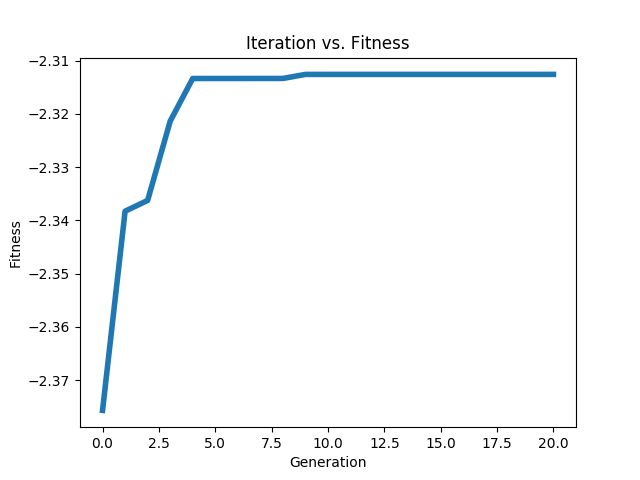

Fitness value of the best solution = -2.312560651693155


In [8]:
pid_controller = train_motor_controller(trajectory, 20, 20)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
Generation = 1
Fitness    = -2.4403614123685284
Generation = 2
Fitness    = -2.4403614123685284
Generation = 3
Fitness    = -2.4403614123685284
Generation = 4
Fitness    = -2.4403614123685284
Generation = 5
Fitness    = -2.4403614123685284


<IPython.core.display.Javascript object>


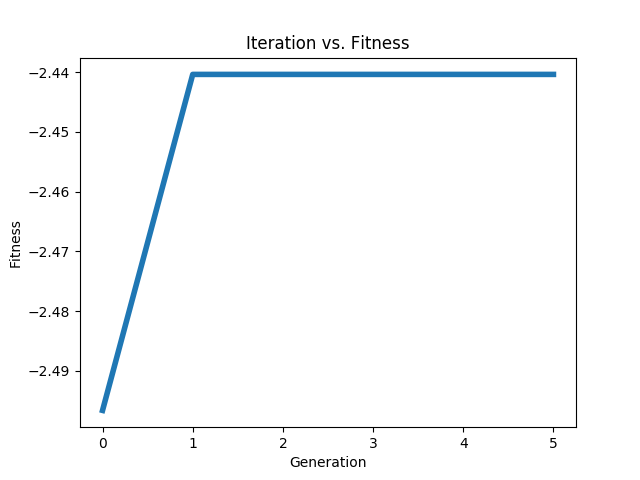

Fitness value of the best solution = -2.4403614123685284


In [9]:
nn_controller = train_motor_controller(trajectory, 5, 20, controller_type='nn', hidden_size=10)

## Testing
In this section, the best controller will be evaluated on the train data and test data

In [10]:
trajectory_test = np.concatenate((trajectory, 0. * np.ones(40)))
trajectory_test = np.concatenate((trajectory_test, 45. * np.ones(40)))
trajectory_test = np.concatenate((trajectory_test, 0. * np.ones(40)))
trajectory_test = np.concatenate((trajectory_test, -25. * np.ones(40)))
trajectory_test = np.concatenate((trajectory_test, 0. * np.ones(40)))

trajectory_test = np.concatenate((trajectory_test, sin_wave(40., 10)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(40., 5)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(30., 2)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(20., 1)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(10., 0.75)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(10., 0.75)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(30., 2)))

In [11]:
evaluator: ModelEvaluator = ModelEvaluator(trajectory_test)

start = time.time()
phy_history_pid, phy_error_pid, phy_u_pid, phy_loss_pid = evaluator.phy_simulate(pid_controller)
print(time.time() - start, 'sec')
nn_history_pid, nn_error_pid, nn_u_pid, nn_loss_pid = evaluator.nn_simulate(pid_controller)

start = time.time()
phy_history_nn, phy_error_nn, phy_u_nn, phy_loss_nn = evaluator.phy_simulate(nn_controller)
print(time.time() - start, 'sec')
nn_history_nn, nn_error_nn, nn_u_nn, nn_loss_nn = evaluator.nn_simulate(nn_controller)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
0.7465901374816895 sec
0.9621016979217529 sec


<IPython.core.display.Javascript object>


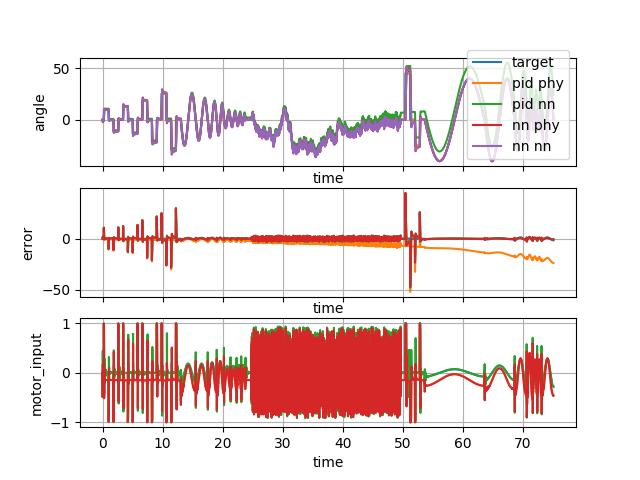

In [12]:
x = np.arange(0., len(trajectory_test) * DT, DT)

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(x, trajectory_test, label='target')
axs[0].plot(x, phy_history_pid, label='pid phy')
axs[0].plot(x, nn_history_pid, label='pid nn')
axs[0].plot(x, phy_history_nn, label='nn phy')
axs[0].plot(x, nn_history_nn, label='nn nn')
axs[0].set_xlabel('time')
axs[0].set_ylabel('angle')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(x, phy_error_pid)
axs[1].plot(x, nn_error_pid)

axs[1].plot(x, phy_error_nn)
axs[1].plot(x, nn_error_nn)
axs[1].set_xlabel('time')
axs[1].set_ylabel('error')
axs[1].grid(True)

axs[2].plot(x, phy_u_pid)
axs[2].plot(x, nn_u_pid)
axs[2].plot(x, phy_u_nn)
axs[2].plot(x, nn_u_nn)
axs[2].set_xlabel('time')
axs[2].set_ylabel('motor_input')
axs[2].grid(True)

In [15]:
torch.save(pid_controller, 'src/data/motor_pid_controller.pt')
torch.save(nn_controller, 'src/data/motor_nn_controller.pt')

/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PidController. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NnController. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
print(pid_controller.predict.weight)

Parameter containing:
tensor([[1.3218, 0.9027, 0.0044]], requires_grad=True)


In [18]:
w = pid_controller.predict.weight[0].detach().numpy().tolist()

motor_pid = {
    'weights': [w[0] * MOTOR_ERROR_SCALING, w[1] * MOTOR_D_ERROR_SCALING, w[2] * MOTOR_INTEGRAL_ERROR_SCALING],
}

with open('src/data/motor_pid.json', 'w') as json_file:
    json.dump(motor_pid, json_file)